In [1]:
import jax
jax.config.update("jax_debug_nans", True)
jax.config.update("jax_disable_jit", True)


In [1]:
# %load tests/inference_test.py
import glob
import os
import unittest
from functools import partial

import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
import xarray as xr
from jax import random
from jax import value_and_grad
from jax.flatten_util import ravel_pytree
from jax.scipy.integrate import trapezoid
from numpyro.infer import MCMC
from numpyro.infer import NUTS
from numpyro.infer.util import unconstrain_fn
from numpyro.infer.util import potential_energy

from gwinferno.models.gwpopulation.gwpopulation import PowerlawRedshiftModel
from gwinferno.models.gwpopulation.gwpopulation import powerlaw_primary_ratio_pdf
from gwinferno.models.bsplines.separable import BSplinePrimaryBSplineRatio
from gwinferno.models.spline_perturbation import PowerlawSplineRedshiftModel
from gwinferno.pipeline.analysis import construct_hierarchical_model
from gwinferno.pipeline.analysis import hierarchical_likelihood
from gwinferno.pipeline.parser import ConfigReader
from gwinferno.pipeline.parser import load_model_from_python_file
from gwinferno.preprocess.data_collection import load_injections
from gwinferno.preprocess.data_collection import load_posterior_data


def norm_mass_model(alpha, beta, mmin, mmax):
    ms = jnp.linspace(3, 100, 500)
    qs = jnp.linspace(0.01, 1, 300)
    mm, qq = jnp.meshgrid(ms, qs)
    p_mq = powerlaw_primary_ratio_pdf(mm, qq, alpha=alpha, beta=beta, mmin=mmin, mmax=mmax)
    return trapezoid(trapezoid(p_mq, qs, axis=0), ms)


class TestModelInference(unittest.TestCase):
    def setUp(self) -> None:
        self.mmin = 5.
        self.mmax = 100.

        if os.path.exists("~/unit_tests/data"):
            pref = "~/unit_tests/data"
        else:
            pref = "tests/data"
        self.data_dir = pref
        self.inj_file = f"{pref}/injections.h5"
        self.param_names = ["mass_1", "mass_ratio", "redshift", "prior"]
        self.param_map = {p: i for i, p in enumerate(self.param_names)}
        self.pedict, self.Nobs, self.Nsamples = self.load_data()
        self.injdict, self.total_inj, self.obs_time = self.load_injections(through_o4a=False, through_o3=True)
        self.parametric_model = self.setup_parametric_model()
        self.bspline_model = self.setup_bspline_model()

    def tearDown(self) -> None:
        del self.data_dir
        del self.inj_file
        del self.pedict
        del self.injdict
        del self.total_inj
        del self.obs_time
        del self.Nobs
        del self.Nsamples
        del self.param_map
        del self.param_names
        del self.z_parametric_model
        del self.mass_bspline_model
        del self.z_bspline_model
        del self.parametric_model
        del self.bspline_model

    def load_data(self, max_samps=100):
        loaded_dataset = xr.load_dataset(f"{self.data_dir}/xarray_GWTC3_BBH_69evs_downsampled_1000samps_nospin.h5")
        dataarray = loaded_dataset.to_array()
        pedata = jnp.asarray(dataarray.data)
        Nobs = pedata.shape[0]
        Nsamples = pedata.shape[-1]
        idxs = np.random.choice(Nsamples, size=max_samps, replace=False)
        pedict = {k: pedata[:, i, idxs] for i, k in enumerate(dataarray.param.values)}
        return pedict, Nobs, max_samps

    def test_load_pe_samples(self):
        fns = glob.glob(f"{self.data_dir}/S*.h5")
        evs = [s.split("/")[-1].replace(".h5", "") for s in fns]
        run_map = {}

        for ev, file in zip(evs, fns):
            run_map[ev] = {"file_path": file, "waveform": "C01:Mixed", "redshift_prior": "euclidean", "catalog": "GWTC-3"}
        p_names = self.param_names.copy()
        p_names.remove("prior")
        pe_catalog = load_posterior_data(run_map=run_map, param_names=p_names)
        pedata = jnp.asarray(pe_catalog.data)
        Nobs = pedata.shape[0]
        Nsamples = pedata.shape[-1]
        self.pedict = {k: pedata[:, i] for i, k in enumerate(pe_catalog.param.values)}
        for param in self.pedict.keys():
            self.assertEqual(self.pedict[param].shape, (Nobs, Nsamples))

    def test_pe_shape(self):
        for param in self.pedict.keys():
            self.assertEqual(self.pedict[param].shape, (self.Nobs, self.Nsamples))

    def load_injections(self, **kwargs):
        p_names = self.param_names.copy()
        p_names.remove("prior")
        injections = load_injections(self.inj_file, p_names, through_o3=kwargs["through_o3"], through_o4a=kwargs["through_o4a"])
        injdata = jnp.asarray(injections.data)
        total_inj = injections.attrs["total_generated"]
        obs_time = injections.attrs["analysis_time"]
        injdict = {k: injdata[i] for i, k in enumerate(injections.param.values)}
        return injdict, float(total_inj), obs_time

    def test_injection_shape(self):
        self.assertGreater(self.total_inj, len(self.injdict[self.param_names[0]]))

    def init_cached_parametric_models(self):
        self.z_parametric_model = PowerlawRedshiftModel(
            z_pe=self.pedict["redshift"],
            z_inj=self.injdict["redshift"],
        )

    def init_bspline_models(self):
        self.m1_nbases = 10
        self.q_nbases = 5
        self.z_nbases = 5
        self.mass_bspline_model = BSplinePrimaryBSplineRatio(
            self.m1_nbases,
            self.q_nbases,
            self.pedict["mass_1"],
            self.injdict["mass_1"],
            self.pedict["mass_ratio"],
            self.injdict["mass_ratio"],
            m1min=self.mmin,
            m2min=self.mmin,
            mmax=self.mmax,
        )
        self.z_bspline_model = PowerlawSplineRedshiftModel(
            self.z_nbases,
            self.pedict["redshift"],
            self.injdict["redshift"],
        )

    def setup_parametric_model(self):
        self.init_cached_parametric_models()
        self.parametric_model_args = (
            self.pedict,
            self.injdict,
            self.z_parametric_model,
            self.Nobs,
            self.total_inj,
            self.obs_time,
        )
        self.parametric_test_params = {
            'alpha': jnp.array(3.5),
            'beta': jnp.array(1.1),
            'lamb': jnp.array(2.9),
            'unscaled_rate': jnp.array(30.),
        }

        def model(pedict, injdict, z_model, Nobs, total_inj, obs_time, sample_prior=False, log_likelihood=False):
            alpha = numpyro.sample("alpha", dist.Normal(0, 2))
            beta = numpyro.sample("beta", dist.Normal(0, 2))
            lamb = numpyro.sample("lamb", dist.Normal(0, 2))
            if not sample_prior:
                def get_weights(m1, q, z, prior):
                    p_m1q = powerlaw_primary_ratio_pdf(m1, q, alpha=alpha, beta=beta, mmin=self.mmin, mmax=self.mmax)
                    p_z = z_model(z, lamb)
                    wts = p_m1q * p_z / prior
                    return jnp.where(jnp.isnan(wts) | jnp.isinf(wts), 0, wts)

                peweights = get_weights(pedict["mass_1"], pedict["mass_ratio"], pedict["redshift"], pedict["prior"])
                injweights = get_weights(injdict["mass_1"], injdict["mass_ratio"], injdict["redshift"], injdict["prior"])
                if not log_likelihood:
                    hierarchical_likelihood(
                        peweights,
                        injweights,
                        total_inj=total_inj,
                        Nobs=Nobs,
                        Tobs=obs_time,
                        surv_hypervolume_fct=z_model.normalization,
                        vtfct_kwargs=dict(lamb=lamb),
                        marginalize_selection=False,
                        min_neff_cut=False,
                        posterior_predictive_check=True,
                        pedata=pedict,
                        injdata=injdict,
                        param_names=[
                            "mass_1",
                            "mass_ratio",
                            "redshift",
                        ],
                        m1min=self.mmin,
                        m2min=self.mmin,
                        mmax=self.mmax,
                    )

                else:
                    hierarchical_likelihood(
                        jnp.log(peweights),
                        jnp.log(injweights),
                        total_inj=total_inj,
                        Nobs=Nobs,
                        Tobs=obs_time,
                        surv_hypervolume_fct=z_model.normalization,
                        vtfct_kwargs=dict(lamb=lamb),
                        marginalize_selection=False,
                        min_neff_cut=False,
                        posterior_predictive_check=True,
                        pedata=pedict,
                        injdata=injdict,
                        param_names=[
                            "mass_1",
                            "mass_ratio",
                            "redshift",
                        ],
                        m1min=self.mmin,
                        m2min=self.mmin,
                        mmax=self.mmax,
                        log=True,
                    )

        return model

    def setup_bspline_model(self):
        self.init_bspline_models()
        self.bspline_test_params = {
            'm1_coefs': random.normal(random.PRNGKey(0), (self.m1_nbases,)),
            'q_coefs': random.normal(random.PRNGKey(1), (self.q_nbases,)),
            'z_coefs': jnp.ones(self.z_nbases),
            'lamb': jnp.array(2.9),
            'unscaled_rate': jnp.array(30.),
        }
        self.bspline_model_args = (
            self.pedict,
            self.injdict,
            self.mass_bspline_model,
            self.z_bspline_model,
            self.Nobs,
            self.total_inj,
            self.obs_time,
        )

        def model(pedict, injdict, mass_model, z_model, Nobs, total_inj, obs_time, sample_prior=False, log_likelihood=False):
            m1_nbases = mass_model.primary_model.n_splines
            q_nbases = mass_model.ratio_model.n_splines
            z_nbases = z_model.n_splines

            m1_coef = numpyro.sample("m1_coefs", dist.Normal(0, 6), sample_shape=(m1_nbases,))
            q_coef = numpyro.sample("q_coefs", dist.Normal(0, 6), sample_shape=(q_nbases,))
            lamb = numpyro.sample("lamb", dist.Normal(0, 3))
            z_coef = numpyro.sample("z_coefs", dist.Normal(0, 6), sample_shape=(z_nbases,))

            if not sample_prior:
                def get_weights(z, prior, pe_samples=False):
                    p_m1q = mass_model(m1_coef, q_coef, pe_samples=pe_samples)
                    p_z = z_model(z, lamb, z_coef)
                    wts = p_m1q * p_z / prior
                    return jnp.where(jnp.isnan(wts) | jnp.isinf(wts), 0, wts)

                peweights = get_weights(pedict["redshift"], pedict["prior"], pe_samples=True)
                injweights = get_weights(injdict["redshift"], injdict["prior"], pe_samples=False)
                if not log_likelihood:
                    hierarchical_likelihood(
                        peweights,
                        injweights,
                        total_inj=total_inj,
                        Nobs=Nobs,
                        Tobs=obs_time,
                        surv_hypervolume_fct=z_model.normalization,
                        vtfct_kwargs=dict(lamb=lamb, cs=z_coef),
                        marginalize_selection=False,
                        min_neff_cut=False,
                        posterior_predictive_check=True,
                        pedata=pedict,
                        injdata=injdict,
                        param_names=[
                            "mass_1",
                            "mass_ratio",
                            "redshift",
                        ],
                        m1min=self.mmin,
                        m2min=self.mmin,
                        mmax=self.mmax,
                    )

                else:
                    hierarchical_likelihood(
                        jnp.log(peweights),
                        jnp.log(injweights),
                        total_inj=total_inj,
                        Nobs=Nobs,
                        Tobs=obs_time,
                        surv_hypervolume_fct=z_model.normalization,
                        vtfct_kwargs=dict(lamb=lamb, cs=z_coef),
                        marginalize_selection=False,
                        min_neff_cut=False,
                        posterior_predictive_check=True,
                        pedata=pedict,
                        injdata=injdict,
                        param_names=[
                            "mass_1",
                            "mass_ratio",
                            "redshift",
                        ],
                        m1min=self.mmin,
                        m2min=self.mmin,
                        mmax=self.mmax,
                        log=True,
                    )

        return model

    def test_parametric_model(self):
        params = unconstrain_fn(
            self.parametric_model,
            self.parametric_model_args,
            {'log_likelihood': False},
            self.parametric_test_params,
        )
        potential_fn = partial(
            potential_energy,
            self.parametric_model,
            self.parametric_model_args,
            {'log_likelihood': False},
        )
        pe, z_grad = value_and_grad(potential_fn)(params)
        z_grad_flat = ravel_pytree(z_grad)[0]
        self.assertTrue(jnp.isfinite(pe), msg="Potential energy is not finite for test case")
        self.assertTrue(jnp.all(jnp.isfinite(z_grad_flat)), msg="Gradient is not finite; don't expect to find valid initial parameters")

    def test_bspline_model(self):
        params = unconstrain_fn(
            self.bspline_model,
            self.bspline_model_args,
            {'log_likelihood': False},
            self.bspline_test_params,
        )
        potential_fn = partial(
            potential_energy,
            self.bspline_model,
            self.bspline_model_args,
            {'log_likelihood': False},
        )
        pe, z_grad = value_and_grad(potential_fn)(params)
        z_grad_flat = ravel_pytree(z_grad)[0]
        self.assertTrue(jnp.isfinite(pe), msg="Potential energy is not finite for test case")
        self.assertTrue(jnp.all(jnp.isfinite(z_grad_flat)), msg="Gradient is not finite; don't expect to find valid initial parameters")

    def test_bspline_model_in_log(self):
        params = unconstrain_fn(
            self.bspline_model,
            self.bspline_model_args,
            {'log_likelihood': True},
            self.bspline_test_params,
        )
        potential_fn = partial(
            potential_energy,
            self.bspline_model,
            self.bspline_model_args,
            {'log_likelihood': True},
        )
        pe, z_grad = value_and_grad(potential_fn)(params)
        z_grad_flat = ravel_pytree(z_grad)[0]
        self.assertTrue(jnp.isfinite(pe), msg="Potential energy is not finite for test case")
        self.assertTrue(jnp.all(jnp.isfinite(z_grad_flat)), msg="Gradient is not finite; don't expect to find valid initial parameters")

    def test_parametric_prior_sample(self):
        RNG = random.PRNGKey(3)
        kernel = NUTS(self.parametric_model, max_tree_depth=2, adapt_mass_matrix=False)
        mcmc = MCMC(kernel, num_warmup=5, num_samples=5)
        mcmc.run(RNG, *self.parametric_model_args, sample_prior=True)
        samples = mcmc.get_samples()
        self.assertEqual(samples["alpha"].shape, (5,))
        self.assertEqual(samples["beta"].shape, (5,))
        self.assertEqual(samples["lamb"].shape, (5,))

    def test_bspline_prior_sample(self):
        RNG = random.PRNGKey(4)
        kernel = NUTS(self.bspline_model, max_tree_depth=2, adapt_mass_matrix=False)
        mcmc = MCMC(kernel, num_warmup=5, num_samples=5)
        mcmc.run(RNG, *self.bspline_model_args, sample_prior=True)
        samples = mcmc.get_samples()
        self.assertEqual(samples["m1_coefs"].shape, (5, self.m1_nbases))
        self.assertEqual(samples["q_coefs"].shape, (5, self.q_nbases))
        self.assertEqual(samples["z_coefs"].shape, (5, self.z_nbases))
        self.assertEqual(samples["lamb"].shape, (5,))

    def test_parametric_posterior_sample(self):
        RNG = random.PRNGKey(5)
        kernel = NUTS(self.parametric_model, max_tree_depth=2, adapt_mass_matrix=False)
        mcmc = MCMC(kernel, num_warmup=5, num_samples=5)
        mcmc.run(RNG, *self.parametric_model_args, sample_prior=False)
        samples = mcmc.get_samples()
        self.assertEqual(samples["alpha"].shape, (5,))
        self.assertEqual(samples["beta"].shape, (5,))
        self.assertEqual(samples["lamb"].shape, (5,))

    def test_bspline_posterior_sample(self):
        RNG = random.PRNGKey(6)
        kernel = NUTS(self.bspline_model, max_tree_depth=2, adapt_mass_matrix=False)
        mcmc = MCMC(kernel, num_warmup=5, num_samples=5)
        mcmc.run(RNG, *self.bspline_model_args, sample_prior=False, log_likelihood=False)
        samples = mcmc.get_samples()
        self.assertEqual(samples["m1_coefs"].shape, (5, self.m1_nbases))
        self.assertEqual(samples["q_coefs"].shape, (5, self.q_nbases))
        self.assertEqual(samples["z_coefs"].shape, (5, self.z_nbases))
        self.assertEqual(samples["lamb"].shape, (5,))

    def test_bspline_posterior_sample_in_log(self):
        RNG = random.PRNGKey(6)
        kernel = NUTS(self.bspline_model, max_tree_depth=2, adapt_mass_matrix=False)
        mcmc = MCMC(kernel, num_warmup=5, num_samples=5)
        mcmc.run(RNG, *self.bspline_model_args, sample_prior=False, log_likelihood=True)
        samples = mcmc.get_samples()
        self.assertEqual(samples["m1_coefs"].shape, (5, self.m1_nbases))
        self.assertEqual(samples["q_coefs"].shape, (5, self.q_nbases))
        self.assertEqual(samples["z_coefs"].shape, (5, self.z_nbases))
        self.assertEqual(samples["lamb"].shape, (5,))

    def test_config_reader(self):
        config_reader = ConfigReader()
        config_reader.parse("gwinferno/pipeline/config_files/example_config.yml")
        model_dict, prior_dict = config_reader.models, config_reader.priors
        data_conf, sampler_conf, likelihood_kwargs = config_reader.data_conf, config_reader.sampler_conf, config_reader.likelihood_kwargs
        sampling_params, label, outdir = config_reader.sampling_params, config_reader.label, config_reader.outdir
        model = construct_hierarchical_model(model_dict, prior_dict, **likelihood_kwargs)
        del data_conf, sampler_conf, sampling_params, label, outdir, model, likelihood_kwargs, prior_dict

    def test_config_py_reader(self):
        config_reader = ConfigReader()
        config_reader.parse("gwinferno/pipeline/config_files/example_config_python_model.yml")
        model_dict, prior_dict = config_reader.models, config_reader.priors
        data_conf, sampler_conf, likelihood_kwargs = config_reader.data_conf, config_reader.sampler_conf, config_reader.likelihood_kwargs
        sampling_params, label, outdir = config_reader.sampling_params, config_reader.label, config_reader.outdir
        model = load_model_from_python_file(model_dict.pop("file_path"))
        self.assertFalse(prior_dict)
        self.assertFalse(model_dict)
        del data_conf, sampler_conf, sampling_params, label, outdir, model, likelihood_kwargs, prior_dict


/Users/bfarr/miniconda3/envs/gwinferno-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
obj = TestModelInference()
obj.setUp()

In [3]:
obj.test_bspline_model_in_log()

AssertionError: Array(False, dtype=bool) is not true : Gradient is not finite; don't expect to find valid initial parameters

In [40]:
from gwinferno.interpolation import BSpline


class LogYBSpline(BSpline):
    def __init__(self, n_df, knots=None, interior_knots=None, xrange=(0, 1), normalize=True, **kwargs):
        """
        Class to construct a basis spline (B-Spline) in the log space of the range (Y)

        Args:
            n_df (int): number of degrees of freedom for the spline
            knots (array_like, optional): array of knots, if non-uniform knot placing is preferred.
                Defaults to None.
            interior_knots (array_like, optional): array of interior knots,
                if non-uniform knot placing is preferred. Defaults to None.
            xrange (tuple, optional): domain of spline. Defaults to (0, 1).
            k (int, optional): order of the spline +1, i.e. cubic splines->k=4. Defaults to 4 (cubic spline).
            normalize (bool, optional): flag whether or not to numerically normalize the spline. Defaults to True.
        """
        super().__init__(n_df, knots=knots, interior_knots=interior_knots, xrange=xrange, **kwargs)
        self.normalize = normalize
        if normalize:
            self.grid = jnp.linspace(*xrange, 1000)
            self.grid_bases = jnp.array(self.bases(self.grid))

    def _project(self, bases, coefs):
        """
        _project given a design matrix (or bases) and coefficients, project the coefficients onto the spline

        Args:
            bases (array_like): The set of basis components or design matrix to project onto
            coefs (array_like): coefficients for the basis components

        Returns:
            array_like: The linear combination of the basis components given the coefficients
        """
        oob = jnp.all(bases == 0, axis=0)
        log_vals = jnp.nan_to_num(jnp.einsum("i...,i->...", bases, coefs), nan=-jnp.inf, posinf=-jnp.inf)
        return jnp.where(oob, 0., jnp.exp(log_vals))  #jnp.where(oob_sel, 0., jnp.exp(log_vals))

    def bases(self, xs):
        """
        Evaluate the basis spline design matrix at xs. We want the probability to ultimately
        be zero outside the range of the spline, but since coefficients can be negative, negative
        infinities for out-of-range values won't have the desired effect.  We'll use nans instead
        and use nan_to_num to convert them to zeros upon projection.

        Args:
            xs (array_like): input values to evaluate the basis spline at

        Returns:
            array_like: the design matrix evaluated at xs. shape (N, *xs.shape)
        """
        design_matrix = super().bases(xs)
        return jnp.where(jnp.less(xs, self.xrange[0]) | jnp.greater(xs, self.xrange[1]), 0, design_matrix)


m1_coefs = random.normal(random.PRNGKey(0), (obj.m1_nbases,))
m1_injs = obj.injdict["mass_1"]

interpolator = LogYBSpline(obj.m1_nbases, xrange=(obj.mmin, obj.mmax), k=4)
interpolator.bases(m1_injs), interpolator.project(interpolator.bases(m1_injs), m1_coefs)

def project_and_sum(coefs):
    bases = interpolator.bases(m1_injs)
    ps = interpolator.project(bases, coefs)
    return jnp.sum(ps)


In [42]:
interpolator.bases(m1_injs), interpolator.project(interpolator.bases(m1_injs), m1_coefs)

(Array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.0982689e-02,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.9712446e-01,
         0.0000000e+00, 5.9485468e-05],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.3804455e-01,
         4.9734544e-02, 2.0447083e-01],
        ...,
        [5.7212418e-01, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [3.7295994e-01, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [6.3911770e-03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32),
 Array([0.01269992, 0.        , 0.00971319, ..., 0.01497306, 0.00768691,
        0.00778277], dtype=float32))

In [41]:
value_and_grad(project_and_sum)(m1_coefs)

(Array(787.7877, dtype=float32),
 Array([  3.8151379,  37.379005 ,  51.93557  ,  35.262177 ,  19.190506 ,
         -3.603035 , -26.832207 , -58.843174 , -52.68307  ,  -5.6216764],      dtype=float32))

In [7]:
params = unconstrain_fn(
    obj.bspline_model,
    obj.bspline_model_args,
    {'log_likelihood': False},
    obj.bspline_test_params,
)
potential_fn = partial(
    potential_energy,
    obj.bspline_model,
    obj.bspline_model_args,
    {'log_likelihood': False},
)
pe, z_grad = value_and_grad(potential_fn)(params)
z_grad_flat = ravel_pytree(z_grad)[0]
pe, z_grad

(Array(404.34778, dtype=float32),
 {'lamb': Array(12.80876, dtype=float32, weak_type=True),
  'm1_coefs': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32),
  'q_coefs': Array([ 0.03343856,  0.11959388, -0.11112669, -0.12035364,  0.08948015],      dtype=float32),
  'unscaled_rate': Array(-38.999996, dtype=float32, weak_type=True),
  'z_coefs': Array([ 0.02790883, -1.9071934 , -7.766446  ,  7.8666506 ,  1.9173056 ],      dtype=float32)})

In [4]:
# @partial(jax.custom_vjp, nondiff_argnums=(1,))
# def _logsumexp(a, axis=None):
#   return _logsumexp_fwd(a, axis)[0]


# def _logsumexp_fwd(a, axis):
#   c = jnp.max(a, axis=axis, keepdims=True)
#   safe = jnp.isfinite(c)
#   c = jnp.where(safe, c, 0)
#   e = jnp.exp(a - c)
#   z = jnp.sum(e, axis=axis, keepdims=True)
#   r = jnp.squeeze(c, axis=axis) + jnp.log(jnp.squeeze(z, axis=axis))
#   return r, (e, z)


# def _logsumexp_bwd(axis, res, g):
#   e, z = res
#   safe = z != 0
#   z = jnp.where(safe, z, 1)
#   if axis is not None:
#     g = jnp.expand_dims(g, axis=axis)
#   return (g / z * e,)


# _logsumexp.defvjp(_logsumexp_fwd, _logsumexp_bwd)

In [10]:
from gwinferno.pipeline.analysis import per_event_log_bayes_factors, detection_efficiency
from gwinferno.models.gwpopulation.gwpopulation import powerlaw_pdf, powerlaw_primary_ratio_falloff_pdf

from jax.scipy.special import logsumexp

mmin = 5.0
mmax = 85.0

def test_fn(alpha, beta, lamb):
    def get_weights(m1, q, z, prior):
        p_m1q = powerlaw_primary_ratio_falloff_pdf(m1, q, alpha, beta, mmin, mmax)
        p_z = obj.z_model(z, lamb)
        wts = p_m1q * p_z / prior
        return jnp.where(jnp.isnan(wts) | jnp.isinf(wts), 0., wts)

    peweights = get_weights(obj.pedict["mass_1"], obj.pedict["mass_ratio"], obj.pedict["redshift"], obj.pedict["prior"])
    log_peweights = jnp.log(peweights)[0]
    logBFs, logn_effs = per_event_log_bayes_factors(jnp.log(peweights), log=True)
    sumlogBFs = jnp.sum(logBFs)

    injweights = get_weights(obj.injdict["mass_1"], obj.injdict["mass_ratio"], obj.injdict["redshift"], obj.injdict["prior"])
    log_det_eff, logn_eff_inj = detection_efficiency(jnp.log(injweights), obj.total_inj, log=True)
    sel = jnp.where(jnp.isinf(log_det_eff), jnp.nan_to_num(-jnp.inf), -obj.Nobs * log_det_eff)
    return sel + sumlogBFs

jax.value_and_grad(test_fn, argnums=[0, 1, 2])(params['alpha'], params['beta'], params['lamb'])

(Array(-541.76337, dtype=float32),
 (Array(nan, dtype=float32, weak_type=True),
  Array(nan, dtype=float32, weak_type=True),
  Array(-14.3321495, dtype=float32, weak_type=True)))

In [167]:
obj.injdict["mass_1"][0:11], obj.injdict["mass_ratio"][0:11], obj.injdict["redshift"][0:11], obj.injdict["prior"][0:11]

(Array([91.0051  ,  4.309117, 49.56017 , 26.805372, 40.136925, 21.145994,
        11.44223 , 46.348957, 30.659395, 50.110634, 87.85397 ],      dtype=float32),
 Array([0.65772885, 0.85667926, 0.9848587 , 0.7555144 , 0.49639475,
        0.91812885, 0.8649236 , 0.8474389 , 0.73924553, 0.7543511 ,
        0.8091375 ], dtype=float32),
 Array([0.7805434 , 0.04101673, 0.7135863 , 0.3317348 , 0.37443125,
        0.22276735, 0.07419356, 0.7007235 , 0.8185534 , 1.0220479 ,
        0.35932612], dtype=float32),
 Array([2.4909657e-06, 1.3025932e-04, 4.3637242e-06, 3.8360307e-04,
        4.4110577e-05, 1.0485483e-03, 8.4313680e-05, 3.3047843e-05,
        1.3868562e-04, 1.9312771e-05, 1.3889327e-06], dtype=float32))

In [146]:
jax.grad(logsumexp)(jnp.array([-jnp.inf, 1]))

Array([0., 1.], dtype=float32)

In [88]:
obj.pedict["mass_1"]

Array([[37.222042, 38.794537, 38.521076, ..., 37.83196 , 35.23149 ,
        36.681793],
       [35.238552, 20.145653, 21.61572 , ..., 21.657352, 22.23512 ,
        31.336054],
       [13.838468, 14.472335, 17.46093 , ..., 18.523546, 11.818629,
        14.029146],
       ...,
       [32.52336 , 33.113285, 39.28318 , ..., 36.120083, 43.093212,
        39.960262],
       [36.327663, 38.29848 , 31.168419, ..., 30.075806, 32.73317 ,
        41.595516],
       [10.173606, 10.632874, 10.648209, ..., 11.229955, 23.964489,
        14.49608 ]], dtype=float32)

In [97]:
m1 = jnp.array([37.222042, 38.222042])
q = jnp.array([0.7, 0.8])
def test_fn(alpha, beta):
    p = powerlaw_pdf(m1, alpha, mmin, mmax)
    p *= powerlaw_pdf(q, beta, mmin / m1, 1.)
    logp = jnp.log(p)
    return jnp.sum(logp)

jax.value_and_grad(test_fn)(params['alpha'], params['beta'])

(Array(-10.689595, dtype=float32),
 Array(-1.1805606, dtype=float32, weak_type=True))

In [66]:
params['alpha']

Array(3.5, dtype=float32, weak_type=True)

In [69]:
jax.value_and_grad(test_fn, argnums=[0, 1, 2])(3.4, params['beta'], params['lamb'])

False


(Array(-0.7106924, dtype=float32),
 (Array(nan, dtype=float32, weak_type=True),
  Array(nan, dtype=float32, weak_type=True),
  Array(nan, dtype=float32, weak_type=True)))

In [13]:
alpha = params['alpha']
beta = params['beta']
lamb = params['lamb']

def get_weights(m1, q, z, prior):
    p_m1q = powerlaw_primary_ratio_pdf(m1, q, alpha=alpha, beta=beta, mmin=mmin, mmax=mmax)
    p_z = obj.z_model(z, lamb)
    wts = p_m1q #* p_z / prior
    return jnp.where(jnp.isnan(wts) | jnp.isinf(wts), 0, wts)

peweights = get_weights(obj.pedict["mass_1"], obj.pedict["mass_ratio"], obj.pedict["redshift"], obj.pedict["prior"])
log_peweights = jnp.log(peweights)
logsumexp(log_peweights, axis=1)

Array([-0.8651271 ,  0.8001795 ,  3.6299875 , -0.6079154 ,  4.65168   ,
       -3.6485028 , -1.1619616 , -0.29104185, -1.3003788 , -2.1649199 ,
        0.1868391 , -1.2089202 , -2.1521144 , -3.8736534 , -2.7231946 ,
       -2.3872986 ,  0.5409837 , -1.7329087 , -1.9217658 , -4.9069266 ,
       -7.5029864 , -2.1691542 , -2.1653085 , -5.0664654 , -4.1885533 ,
       -1.1731505 , -3.6546698 , -5.474626  ,  4.1554804 ,  2.0325143 ,
       -2.3829193 ,  3.60317   ,  4.1989326 , -2.5409803 ,  3.8498368 ,
       -2.9009933 , -2.4228444 , -4.134282  , -1.2612314 ,  0.24930048,
       -2.4362426 , -1.2568278 ,  5.913206  ,  1.1792684 , -5.4201097 ,
        3.9392762 ,  3.9270186 ,  4.283895  , -4.15062   , -3.6209235 ,
        4.599425  ,  4.0763083 , -0.09750271,  4.2619743 , -3.1207128 ,
       -3.9913783 , -1.3506789 , -2.9977183 , -1.0704803 ,  5.035596  ,
       -2.1173368 , -2.2194986 , -4.0495105 , -2.4544926 , -2.1044888 ,
        1.4634228 , -1.8623061 , -1.1537662 ,  3.4087162 ], dtyp

In [17]:
m1 = 50.
q = .9
alpha = -2.
beta = -2.
mmin = 5.0
mmax = 85.0

grad_pdf = jax.grad(powerlaw_primary_ratio_pdf)
grad_pdf(m1, q, alpha, beta, mmin, mmax)

Array(2.9788102e-05, dtype=float32, weak_type=True)

In [4]:
import numpyro
numpyro.enable_validation()

In [5]:
obj.test_truncated_posterior_sample_in_log()

RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [5]:
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp

In [6]:
Nobs = 100
ndim = 7
Nsamples = 10000

cdfs = jr.uniform(jr.PRNGKey(0), (Nobs, Nsamples, ))

pe_weights = jsp.stats.norm.ppf(cdfs)
log_pe_weights = jnp.log(pe_weights)

In [7]:
Nfound = 1000000
Ninj = 1e8

cdfs = jr.uniform(jr.PRNGKey(0), (Nfound,))

inj_weights = jsp.stats.norm.ppf(cdfs)
log_inj_weights = jnp.log(inj_weights)

In [4]:
from gwinferno.pipeline.analysis import per_event_log_bayes_factors
from gwinferno.pipeline.analysis import detection_efficiency

/Users/bfarr/miniconda3/envs/gwinferno-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
per_event_log_bayes_factors(pe_weights, log=False)

(Array([       nan, -6.28279  ,        nan, -5.4024377,        nan,
        -4.6986156, -4.899934 ,        nan,        nan, -3.7848063,
        -3.8085396, -5.0981064,        nan,        nan, -5.612026 ,
               nan, -4.9878507,        nan, -4.642298 , -5.3807797,
               nan,        nan,        nan,        nan, -4.2844276,
               nan, -4.0309176,        nan, -5.3119984,        nan,
        -6.2375903,        nan, -6.5961385,        nan, -6.9297085,
        -4.2152176,        nan, -6.1705165, -3.8763113,        nan,
        -4.013441 ,        nan,        nan,        nan,        nan,
               nan,        nan, -4.6851406,        nan, -4.865668 ,
               nan,        nan, -4.1963224, -8.891895 , -8.230718 ,
        -6.123764 ,        nan,        nan, -5.561819 ,        nan,
               nan,        nan,        nan,        nan,        nan,
        -4.3325586, -4.035114 , -4.12204  ,        nan, -4.727278 ,
        -6.9177628, -4.6817   , -4.6184473, -5.4

In [9]:
%timeit per_event_log_bayes_factor_log_neffs(pe_weights)

1.18 ms ± 33.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
%timeit per_event_log_bayes_factor_log_neffs_log(jnp.log(pe_weights))

8.56 ms ± 11.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit mu_neff_injections(weights, Nfound)

395 μs ± 3.12 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%timeit logmu_logneff_injections_log(log_weights, Nfound)

4.11 ms ± 61.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1]:
# %load tests/models/bsplines/separable_test.py
import os
import unittest

import jax.numpy as jnp
import xarray as xr

from gwinferno.models.bsplines.separable import BSplineEffectiveSpinDims
from gwinferno.models.bsplines.separable import BSplineIIDComponentMasses
from gwinferno.models.bsplines.separable import BSplineIIDSpinMagnitudes
from gwinferno.models.bsplines.separable import BSplineIIDSpinTilts
from gwinferno.models.bsplines.separable import BSplineIndependentComponentMasses
from gwinferno.models.bsplines.separable import BSplineIndependentSpinMagnitudes
from gwinferno.models.bsplines.separable import BSplineIndependentSpinTilts
from gwinferno.models.bsplines.separable import BSplinePrimaryBSplineRatio
from gwinferno.models.bsplines.separable import BSplinePrimaryPowerlawRatio
from gwinferno.models.bsplines.separable import PLPeakPrimaryBSplineRatio
from gwinferno.preprocess.data_collection import load_injections


class TestBase1DBSplineModel(unittest.TestCase):
    def setUp(self) -> None:
        if os.path.exists("~/unit_tests/data"):
            pref = "~/unit_tests/data"
        else:
            pref = "tests/data"
            self.data_dir = pref
        self.inj_file = f"{pref}/injections.h5"
        self.pedict = self.load_data()
        self.injdict = self.load_injections(through_o4a=False, through_o3=True)
        self.nsplines = 10
        self.coefs = jnp.ones((self.nsplines,))
        self.mmin = 5.0
        self.mmax = 100.0

    def tearDown(self) -> None:
        del self.data_dir
        del self.inj_file
        del self.pedict
        del self.injdict
        del self.nsplines
        del self.mmin
        del self.mmax

    def load_injections(self, **kwargs):
        p_names = ["mass_1", "mass_ratio", "redshift", "a_1", "a_2", "cos_tilt_1", "cos_tilt_2"]
        injections = load_injections(self.inj_file, p_names, through_o3=kwargs["through_o3"], through_o4a=kwargs["through_o4a"])
        injdata = jnp.asarray(injections.data)
        injdict = {k: injdata[i] for i, k in enumerate(injections.param.values)}
        return injdict

    def load_data(self):
        loaded_dataset = xr.load_dataset(f"{self.data_dir}/xarray_GWTC3_BBH_69evs_downsampled_1000samps_nospin.h5")
        dataarray = loaded_dataset.to_array()
        pedata = jnp.asarray(dataarray.data)
        pedict = {k: pedata[:, i, :] for i, k in enumerate(dataarray.param.values)}
        return pedict

    def spin_spline_shape(self, model, pe_x, inj_x, IID=True):

        if IID:
            bspline = model(self.nsplines, pe_x, pe_x, inj_x, inj_x)
            pe_pdf = bspline(self.coefs, pe_samples=True)
            inj_pdf = bspline(self.coefs, pe_samples=False)
        else:
            bspline = model(self.nsplines, self.nsplines, pe_x, pe_x, inj_x, inj_x)
            pe_pdf = bspline(self.coefs, self.coefs, pe_samples=True)
            inj_pdf = bspline(self.coefs, self.coefs, pe_samples=False)

        self.assertEqual(pe_x.shape, pe_pdf.shape, msg="PE sample shape different than PE PDF shape")
        self.assertEqual(inj_x.shape, inj_pdf.shape, msg="Inj sample shape different than Inj PDF shape")

    def test_spin_functions(self):
        self.spin_spline_shape(BSplineIIDSpinMagnitudes, self.pedict["a_1"], self.injdict["a_1"])
        self.spin_spline_shape(BSplineIIDSpinTilts, self.pedict["cos_tilt_1"], self.injdict["cos_tilt_1"])
        self.spin_spline_shape(BSplineIndependentSpinMagnitudes, self.pedict["a_1"], self.injdict["a_1"], IID=False)
        self.spin_spline_shape(BSplineIndependentSpinTilts, self.pedict["cos_tilt_1"], self.injdict["cos_tilt_1"], IID=False)

    def test_BSplinePrimaryPowerlawRatio(self):
        beta = 3.0

        pe_m1 = self.pedict["mass_1"]
        inj_m1 = self.injdict["mass_1"]
        pe_q = self.pedict["mass_ratio"]
        inj_q = self.injdict["mass_ratio"]
        bspline_pl = BSplinePrimaryPowerlawRatio(self.nsplines, pe_m1, inj_m1, mmin=self.mmin, mmax=self.mmax)

        pe_pdf = bspline_pl(pe_m1, pe_q, beta, self.mmin, self.coefs, pe_samples=True)
        inj_pdf = bspline_pl(inj_m1, inj_q, beta, self.mmin, self.coefs, pe_samples=False)

        self.assertEqual(pe_m1.shape, pe_pdf.shape, msg="PE sample shape different than PE PDF shape")
        self.assertEqual(inj_m1.shape, inj_pdf.shape, msg="Inj sample shape different than Inj PDF shape")

        pe_nonzero_outside = jnp.sum(jnp.where(jnp.less(pe_m1, self.mmin) | jnp.greater(pe_m1, self.mmax), pe_pdf, 0))
        inj_nonzero_outside = jnp.sum(jnp.where(jnp.less(inj_m1, self.mmin) | jnp.greater(inj_m1, self.mmax), inj_pdf, 0))

        self.assertEqual(pe_nonzero_outside, 0, msg="PE PDF not properly truncated")
        self.assertEqual(inj_nonzero_outside, 0, msg="Inj PDF not properly truncated")

    def test_PLPeakPrimaryBSplineRatio(self):

        pe_m1 = self.pedict["mass_1"]
        inj_m1 = self.injdict["mass_1"]
        pe_q = self.pedict["mass_ratio"]
        inj_q = self.injdict["mass_ratio"]

        plpeak_spline = PLPeakPrimaryBSplineRatio(self.nsplines, pe_q, inj_q)

        pe_pdf = plpeak_spline(pe_m1, self.coefs, pe_samples=True, alpha=-3, mmin=self.mmin, mmax=self.mmax, mpp=10.0, sigpp=3.0, lam=0.8)
        inj_pdf = plpeak_spline(inj_m1, self.coefs, pe_samples=False, alpha=-3, mmin=self.mmin, mmax=self.mmax, mpp=10.0, sigpp=3.0, lam=0.8)

        self.assertEqual(pe_m1.shape, pe_pdf.shape, msg="PE sample shape different than PE PDF shape")
        self.assertEqual(inj_m1.shape, inj_pdf.shape, msg="Inj sample shape different than Inj PDF shape")

        pe_nonzero_outside = jnp.sum(jnp.where(jnp.less(pe_m1, self.mmin) | jnp.greater(pe_m1, self.mmax), pe_pdf, 0))
        inj_nonzero_outside = jnp.sum(jnp.where(jnp.less(inj_m1, self.mmin) | jnp.greater(inj_m1, self.mmax), inj_pdf, 0))

        self.assertEqual(pe_nonzero_outside, 0, msg="PE PDF not properly truncated")
        self.assertEqual(inj_nonzero_outside, 0, msg="Inj PDF not properly truncated")

    def test_BSplinePrimaryBSplineRatio(self):

        pe_m1 = self.pedict["mass_1"]
        inj_m1 = self.injdict["mass_1"]
        pe_q = self.pedict["mass_ratio"]
        inj_q = self.injdict["mass_ratio"]

        spline = BSplinePrimaryBSplineRatio(
            self.nsplines, self.nsplines, pe_m1, inj_m1, pe_q, inj_q, m1min=self.mmin, m2min=self.mmin, mmax=self.mmax
        )

        pe_pdf = spline(self.coefs, self.coefs, pe_samples=True)
        inj_pdf = spline(self.coefs, self.coefs, pe_samples=False)

        self.assertEqual(pe_m1.shape, pe_pdf.shape, msg="PE sample shape different than PE PDF shape")
        self.assertEqual(inj_m1.shape, inj_pdf.shape, msg="Inj sample shape different than Inj PDF shape")

        pe_nonzero_outside = jnp.sum(jnp.where(jnp.less(pe_m1, self.mmin) | jnp.greater(pe_m1, self.mmax), pe_pdf, 0))
        inj_nonzero_outside = jnp.sum(jnp.where(jnp.less(inj_m1, self.mmin) | jnp.greater(inj_m1, self.mmax), inj_pdf, 0))

        self.assertEqual(pe_nonzero_outside, 0, msg="PE PDF not properly truncated")
        self.assertEqual(inj_nonzero_outside, 0, msg="Inj PDF not properly truncated")

    def component_mass(self, model, IID=True, **kwargs):

        pe_m1 = self.pedict["mass_1"]
        inj_m1 = self.injdict["mass_1"]
        pe_m2 = self.pedict["mass_ratio"] * self.pedict["mass_1"]
        inj_m2 = self.injdict["mass_ratio"] * self.injdict["mass_1"]

        if IID:
            spline = model(self.nsplines, pe_m1, pe_m2, inj_m1, inj_m2, **kwargs)
            pe_pdf = spline(self.coefs, beta=3.0, pe_samples=True)
            inj_pdf = spline(self.coefs, beta=3.0, pe_samples=False)
        else:
            spline = model(self.nsplines, self.nsplines, pe_m1, pe_m2, inj_m1, inj_m2, **kwargs)
            pe_pdf = spline(self.coefs, self.coefs, beta=3.0, pe_samples=True)
            inj_pdf = spline(self.coefs, self.coefs, beta=3.0, pe_samples=False)

        self.assertEqual(pe_m1.shape, pe_pdf.shape, msg="PE sample shape different than PE PDF shape")
        self.assertEqual(inj_m1.shape, inj_pdf.shape, msg="Inj sample shape different than Inj PDF shape")

    def test_BSplineComponentMass(self):

        self.component_mass(BSplineIIDComponentMasses, IID=True, mmin=self.mmin, mmax=self.mmax)
        self.component_mass(BSplineIndependentComponentMasses, IID=False, mmin1=self.mmin, mmax1=self.mmax, mmin2=self.mmin, mmax2=self.mmax)

    def test_BSplineEffectiveSpinDims(self):

        spline = BSplineEffectiveSpinDims(
            self.nsplines, self.nsplines, self.pedict["cos_tilt_1"], self.pedict["a_1"], self.injdict["cos_tilt_1"], self.injdict["a_1"]
        )

        pe_pdf = spline(self.coefs, self.coefs, pe_samples=True)
        inj_pdf = spline(self.coefs, self.coefs, pe_samples=False)

        self.assertEqual(self.pedict["a_1"].shape, pe_pdf.shape, msg="PE sample shape different than PE PDF shape")
        self.assertEqual(self.injdict["cos_tilt_1"].shape, inj_pdf.shape, msg="Inj sample shape different than Inj PDF shape")


/Users/bfarr/miniconda3/envs/gwinferno-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_obj = TestBase1DBSplineModel()
test_obj.setUp()

In [3]:
test_obj.test_BSplinePrimaryBSplineRatio()

In [4]:
pe_m1 = test_obj.pedict["mass_1"]
inj_m1 = test_obj.injdict["mass_1"]
pe_q = test_obj.pedict["mass_ratio"]
inj_q = test_obj.injdict["mass_ratio"]
spline = BSplinePrimaryBSplineRatio(
    test_obj.nsplines, test_obj.nsplines, pe_m1, inj_m1, pe_q, inj_q, m1min=test_obj.mmin, m2min=test_obj.mmin, mmax=test_obj.mmax
)

In [15]:
pe_pdf = spline(test_obj.coefs, test_obj.coefs, pe_samples=True)
inj_pdf = spline(test_obj.coefs, test_obj.coefs, pe_samples=False)
pe_pdf, inj_pdf

(Array([[0.01108033, 0.01108033, 0.01108033, ..., 0.01108033, 0.01108033,
         0.01108033],
        [0.01108033, 0.01108033, 0.01108033, ..., 0.01108033, 0.01108033,
         0.01108033],
        [0.01108033, 0.01108033, 0.01108033, ..., 0.01108033, 0.01108033,
         0.01108033],
        ...,
        [0.01108033, 0.01108033, 0.01108033, ..., 0.01108033, 0.01108033,
         0.01108033],
        [0.01108033, 0.01108033, 0.01108033, ..., 0.01108033, 0.01108033,
         0.01108033],
        [0.01108033, 0.01108033, 0.01108033, ..., 0.01108033, 0.01108033,
         0.01108033]], dtype=float32),
 Array([0.01108033, 0.00407623, 0.01108033, ..., 0.01108033, 0.01108033,
        0.01108033], dtype=float32))

In [16]:
import matplotlib.pyplot as plt

In [21]:
inj_m1_pdf = spline.primary_model(test_obj.coefs, pe_samples=False)

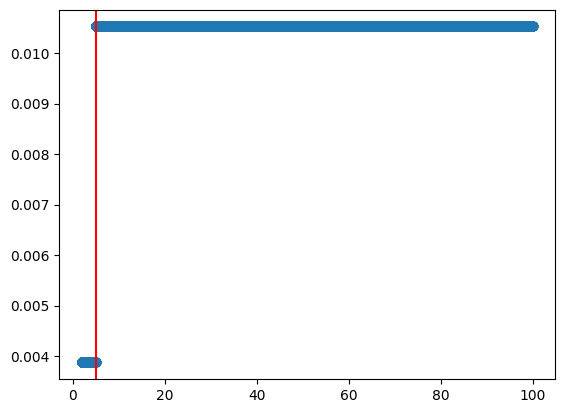

In [24]:
plt.scatter(inj_m1, inj_m1_pdf)
plt.axvline(test_obj.mmin, color="r")

In [28]:
test_x = 4.9
spline.primary_model.truncate_dmat(jnp.array([test_x,]),spline.primary_model.interpolator.bases(jnp.array([test_x,])) )

Array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [31]:
out_of_bounds_inj = inj_m1 < test_obj.mmin

In [36]:
spline.primary_model.inj_design_matrix[:, out_of_bounds_inj].sum()

Array(0., dtype=float32)

In [39]:
spline.primary_model.interpolator.project(spline.primary_model.inj_design_matrix, test_obj.coefs)[out_of_bounds_inj]

Array([0.00387242, 0.00387242, 0.00387242, ..., 0.00387242, 0.00387242,
       0.00387242], dtype=float32)

In [43]:
jnp.exp(jnp.einsum("i...,i->...", spline.primary_model.inj_design_matrix, test_obj.coefs)[out_of_bounds_inj])

Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [1]:
# %load tests/numpyro_distributions_test.py
import unittest

import jax.numpy as jnp
import numpy as np
from astropy.cosmology import Planck15
from jax import random
from jax.scipy.integrate import trapezoid
from scipy.integrate import cumtrapz as scipy_cumtrapz
from scipy.stats import truncnorm

from gwinferno.interpolation import BSpline
from gwinferno.interpolation import LogXBSpline
from gwinferno.interpolation import LogXLogYBSpline
from gwinferno.interpolation import LogYBSpline
from gwinferno.numpyro_distributions import BSplineDistribution
from gwinferno.numpyro_distributions import Cosine
from gwinferno.numpyro_distributions import Powerlaw
from gwinferno.numpyro_distributions import PowerlawRedshift
from gwinferno.numpyro_distributions import PSplineCoeficientPrior
from gwinferno.numpyro_distributions import Sine
from gwinferno.numpyro_distributions import cumtrapz


class TestJaxCumtrapz(unittest.TestCase):
    def setUp(self) -> None:
        self.gr = np.linspace(0, 1, 50)
        self.tn = truncnorm(-1, 1, loc=0.5, scale=0.1)

    def test_cumtrapz(self):
        scipy_int = scipy_cumtrapz(np.exp(self.tn.logpdf(self.gr)), self.gr).tolist()
        gwinf_int = cumtrapz(jnp.exp(self.tn.logpdf(self.gr)), self.gr).tolist()
        for s, g in zip(scipy_int, gwinf_int):
            self.assertAlmostEqual(s, g, places=4)

    def tearDown(self) -> None:
        del self.gr
        del self.tn


class TestNPDistributions(unittest.TestCase):
    def setUp(self) -> None:
        self.grid = jnp.linspace(0.001, 1, 1000)
        self.x_interps = jnp.linspace(0.001, 1, 10)
        self.y_interps = random.normal(random.PRNGKey(0), shape=(10,))
        self.gr = jnp.linspace(0, 1, 1000)
        self.cs_pn = random.normal(random.PRNGKey(1), shape=(20,))
        self.cs = random.uniform(random.PRNGKey(2), shape=(20,))

    def tearDown(self) -> None:
        del self.grid
        del self.x_interps
        del self.y_interps
        del self.gr
        del self.cs

    def test_cosine(self):
        d = Cosine(minimum=-np.pi / 2.0, maximum=np.pi / 2.0)
        grid = np.linspace(-np.pi / 2.0, np.pi / 2.0, 1000)
        lpdfs = d.log_prob(grid)
        self.assertAlmostEqual(trapezoid(jnp.exp(lpdfs), grid), 1.0, places=4)
        samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
        self.assertTrue(jnp.all((samps >= -np.pi / 2.0) & (samps <= np.pi / 2.0)))

    def test_sine(self):
        d = Sine(minimum=0.0, maximum=np.pi)
        grid = np.linspace(0, np.pi, 1000)
        lpdfs = d.log_prob(grid)
        self.assertAlmostEqual(trapezoid(jnp.exp(lpdfs), grid), 1.0, places=4)
        samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
        self.assertTrue(jnp.all((samps >= 0.0) & (samps <= np.pi)))

    def test_powerlaw(self):
        d = Powerlaw(alpha=1.0, minimum=0.001, maximum=1.0)
        lpdfs = d.log_prob(self.grid)
        norm = trapezoid(jnp.exp(lpdfs), self.grid)
        self.assertAlmostEqual(norm, 1.0, places=4)
        samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
        self.assertTrue(jnp.all((samps >= 0.001) & (samps <= 1.0)))

    def test_powerlaw_redshift(self):
        z_grid = jnp.linspace(0.001, 1, 1000)
        dVcdz_grid = Planck15.differential_comoving_volume(z_grid).value * 4.0 * jnp.pi
        d = PowerlawRedshift(lamb=0.0, maximum=1.0, zgrid=z_grid, dVcdz=dVcdz_grid)
        lpdfs = d.log_prob(self.grid)
        norm = trapezoid(jnp.exp(lpdfs), self.grid)
        self.assertAlmostEqual(norm, 1.0, places=4)
        samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
        self.assertTrue(jnp.all((samps >= 0.001) & (samps <= 1.0)))

    def test_bspline_distribution(self):
        grid_dmat = BSpline(20, normalize=True).bases(self.gr)
        d = BSplineDistribution(minimum=0.0, maximum=1.0, cs=self.cs, grid=self.gr, grid_dmat=grid_dmat)
        lpdfs = d.log_prob(self.gr)
        norm = trapezoid(jnp.exp(lpdfs), self.gr)
        self.assertAlmostEqual(norm, 1.0, places=4)
        samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
        self.assertTrue(jnp.all((samps >= 0.0) & (samps <= 1.0)))

    def test_pspline_distribution(self):
        cs = PSplineCoeficientPrior(20, 1.0).sample(random.PRNGKey(0), sample_shape=(1,))
        grid_dmat = BSpline(20, normalize=True).bases(self.gr)
        d = BSplineDistribution(minimum=0.0, maximum=1.0, cs=cs, grid=self.gr, grid_dmat=grid_dmat)
        lpdfs = d.log_prob(self.gr)
        norm = trapezoid(jnp.exp(lpdfs), self.gr)
        self.assertAlmostEqual(norm, 1.0, places=4)
        samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
        self.assertTrue(jnp.all((samps >= 0.0) & (samps <= 1.0)))

    def test_logy_bspline_distribution(self):
        grid_dmat = LogYBSpline(20, normalize=True).bases(self.gr)
        d = BSplineDistribution(minimum=0.0, maximum=1.0, cs=self.cs_pn, grid=self.gr, grid_dmat=grid_dmat)
        lpdfs = d.log_prob(self.gr)
        norm = trapezoid(jnp.exp(lpdfs), self.gr)
        self.assertAlmostEqual(norm, 1.0, places=4)
        samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
        self.assertTrue(jnp.all((samps >= 0.0) & (samps <= 1.0)))

    def test_logx_bspline_distribution(self):
        grid_dmat = LogXBSpline(20, normalize=True).bases(self.grid)
        d = BSplineDistribution(minimum=0.001, maximum=1.0, cs=self.cs, grid=self.grid, grid_dmat=grid_dmat)
        lpdfs = d.log_prob(self.grid)
        norm = trapezoid(jnp.exp(lpdfs), self.grid)
        self.assertAlmostEqual(norm, 1.0, places=4)
        samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
        self.assertTrue(jnp.all((samps >= 0.001) & (samps <= 1.0)))

    def test_logxy_bspline_distribution(self):
        grid_dmat = LogXLogYBSpline(20, normalize=True).bases(self.grid)
        d = BSplineDistribution(minimum=0.001, maximum=1.0, cs=self.cs_pn, grid=self.grid, grid_dmat=grid_dmat)
        lpdfs = d.log_prob(self.grid)
        norm = trapezoid(jnp.exp(lpdfs), self.grid)
        self.assertAlmostEqual(norm, 1.0, places=4)
        samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
        self.assertTrue(jnp.all((samps >= 0.001) & (samps <= 1.0)))


/Users/bfarr/miniconda3/envs/gwinferno-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_obj = TestNPDistributions()
test_obj.setUp()

In [3]:
test_obj.test_logxy_bspline_distribution()

In [10]:
spline = LogXLogYBSpline(20, normalize=True)
grid_dmat = spline.bases(test_obj.grid)
d = BSplineDistribution(minimum=0.001, maximum=1.0, cs=test_obj.cs_pn, grid=test_obj.grid, grid_dmat=grid_dmat)
spline.project(grid_dmat, test_obj.cs_pn)

Array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
norm = trapezoid(jnp.exp(lpdfs), test_obj.grid)
test_obj.assertAlmostEqual(norm, 1.0, places=4)
samps = d.sample(random.PRNGKey(0), sample_shape=(100,))
test_obj.assertTrue(jnp.all((samps >= 0.001) & (samps <= 1.0)))
